# Particle Neural Network

In [1]:
from MakeData import MakeData
from ParticleNet import ParticleNet
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from mpl_toolkits import mplot3d
import neural_structured_learning as nsl
from collections import defaultdict
params = 5

In [2]:
p = 100
Ntrain = 10
Ntest = 10

In [3]:
train,train_vals = MakeData(p,Ntrain)
test,test_vals = MakeData(p,Ntest)

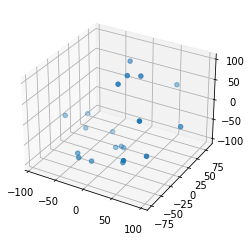

In [4]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(train[:,0], train[:,1], train[:,2]);

(0.0, 400.0)

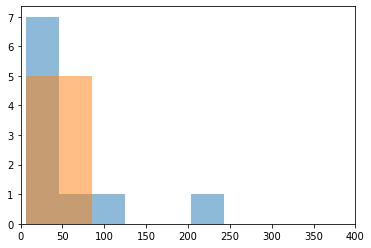

In [5]:
n,bins,weights = plt.hist(train[train_vals==0,3], bins = 'auto', alpha = 0.5)
plt.hist(train[train_vals==1,3], bins = bins, alpha = 0.5)
plt.xlim(0,400)

(0.0, 2500.0)

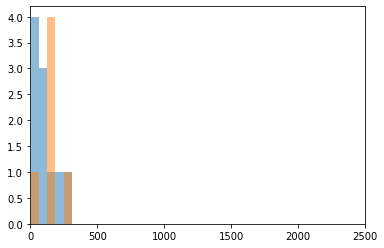

In [6]:
n,bins,weights = plt.hist(train[train_vals==0,4], bins = 'auto', alpha = 0.5)
plt.hist(train[train_vals==1,4], bins = bins, alpha = 0.5)
plt.xlim(0,2500)

In [7]:
print(test_vals[0:20])

[1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0.]


In [8]:
train_data = [[]]
for i in range(Ntrain*2):
    train_data.append(np.array([train[i,:],train_vals[i]]))
    train_data.append(np.array([train[i,:]],train_vals[i]))

<ipython-input-8-27b5978335fd>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  train_data.append(np.array([train[i,:],train_vals[i]]))


In [9]:
# predictions = ParticleNet(train,train_vals,test) # NOTE KEEP THIS FOR COMPARISONS

# Base Model

In [10]:
def build_base_model():
    '''Builds the Basic Model'''
    input_shape = (1,1)
    inputs = [tf.keras.Input(shape=input_shape, dtype=tf.float32, name=name) for name in FEATURE_INPUT_NAME]
#    inputs = tf.keras.Input(shape=(5,))
    print(inputs)
    
    x = tf.keras.layers.concatenate(inputs = [*inputs], axis=-1, name = 'concat')

    
    print(x)
    
    x = tf.keras.layers.Conv1D(64, 3, padding = 'same', activation='relu', name = 'conv1')(x)
    x = tf.keras.layers.Conv1D(64, 1, padding = 'same', activation='relu', name = 'conv2')(x)
#    x = tf.keras.layers.MaxPool1D(2)(x)
    x = tf.keras.layers.Conv1D(32, 3, padding = 'same', activation='relu', name = 'conv3')(x)
    x = tf.keras.layers.Conv1D(32, 1, padding = 'same', activation='relu', name = 'conv4')(x)
#    x = tf.keras.layers.MaxPool1D(2)(x)
    x = tf.keras.layers.Flatten(name = 'flatten')(x)
    x = tf.keras.layers.Dense(64, activation='relu', name = 'relu')(x)
    pred = tf.keras.layers.Dense(2, activation='softmax', name = 'output')(x) 
    model = tf.keras.Model(inputs=[*inputs], outputs=pred)

    return model

In [11]:
FEATURE_INPUT_NAME = ['Px','Py','Pz','Mass','Tau']
base_model = build_base_model()
base_model.summary()

[<KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'Px')>, <KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'Py')>, <KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'Pz')>, <KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'Mass')>, <KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'Tau')>]
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 5), dtype=tf.float32, name=None), name='concat/concat:0', description="created by layer 'concat'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Px (InputLayer)                 [(None, 1, 1)]       0                                            
__________________________________________________________________________________________________
Py (InputLayer)                 [(None, 1, 1)]       0                  

In [12]:
base_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                   metrics=['acc'])

base_model.fit((train[:,0],train[:,1],train[:,2],train[:,3],train[:,4]),train_vals, epochs=1)

1/1 [==============================] - 1s 634ms/step - loss: 1.0705 - acc: 0.5000


# Adversarial Model

In [13]:
adv_train = defaultdict(np.array)
list_train_vals = train_vals
for A, B in zip(list_train_vals, train):
    adv_train[A] = B
#adv_train['labels'] = (0,1)

In [14]:
print(adv_train)

defaultdict(<built-in function array>, {0.0: array([-32.05653308, -52.67493021, -78.72566554,  38.51134022,
         2.39603372]), 1.0: array([ 82.9644679 , -46.96568953, -30.18478214,  36.85222766,
       272.88924411])})


In [15]:
base_adv_model = build_base_model()
adv_model = nsl.keras.AdversarialRegularization(
    base_adv_model,
    label_keys = ['labels']
)

[<KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'Px')>, <KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'Py')>, <KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'Pz')>, <KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'Mass')>, <KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'Tau')>]
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 5), dtype=tf.float32, name=None), name='concat/concat:0', description="created by layer 'concat'")


In [16]:
adv_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                   metrics=['acc'])
# Input - make input list inside list have np.array of data and 1 of labels np array, same length, different shape,
# data first, labels second
#adv_model.fit(x=(train[:,0],train[:,1],train[:,2],train[:,3],train[:,4])s,y=train_vals, epochs=1)
adv_model.fit(x={'input': (train[:,0],train[:,1],train[:,2],train[:,3],train[:,4]),'labels': train_vals}, epochs=1)
#adv_model.fit(train,train_vals, epochs=1)

StagingError: in user code:

    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/neural_structured_learning/keras/adversarial_regularization.py:667 call  *
        outputs, labeled_loss, metrics, tape = self._forward_pass(
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/neural_structured_learning/keras/adversarial_regularization.py:646 _forward_pass  *
        outputs = self._call_base_model(inputs, **base_model_kwargs)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/neural_structured_learning/keras/adversarial_regularization.py:635 _call_base_model  *
        inputs = [inputs[name] for name in base_input_names]

    KeyError: 'Px'
